In [1]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.stats
import scipy.optimize

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['font.size'] = 15

# Calculating clustering: running `xirunpc.py`

First, you need to download the entire LSS directory from https://github.com/desihub/LSS . `xirunpc.py` is a code that calculates various clustering measures for a given sample. I have saved my edited version in this repository, which has aditions for volume-limited samples and splitting samples by colour. You are welcome to use this as a starting point but given other changes to the LSS repository since my time it may be out of date!

`xirunpc.py` is a computation-heavy program so *should not be run directly on login nodes*. You need to use batch scripts to submit the job to a queue, giving the computer all the instructions to run it, and wait. NERSC uses SLURM for job scheduling - see https://docs.nersc.gov/jobs/

I have copied an example batch script below, which I named `measure_clustering_sv3_17_18_colour.sh`, which calculates clustering for a volume-limited sample between magnitude limits of -17 to -18 for SV3, splitting the sample into red and blue.

The #SBATCH lines at the start are instructions for the computer.
Things to change:
- `-q` describes which node to run on, can also be 'regular' (which I needed for some more intensive DA0.2 jobs)
- `-o` describes where to save output log files. The folder you point it to (i.e. `../../logs/logs_clustering_sv3/`in this case) needs to exist. You can look at these files to check on the progress of the program and help narrow down possible errors. Change this to match your file structure.
- `--time` gives the maximum time limit (in minutes) for the program to help with scheduling. A longer time may mean it takes longer for your job to begin running (as SLURM has to have a bigger gap to fit it in), but if your program reaches its time limit it will be automatically terminated, so give a generous guess.
- `--mail-type` and `--mail-user` set up automatic email notifications to the address specified (change!!) when your jobs start/finish, which is helpful so you don't need to check up on them all the time. If they run into errors, it will also give you an error code corresponding to why it ended. You can also remove these lines to remove email notifications.

Things not to change:
- `--nodes` and `--tasks-per-node` are for parallelisation which (I don't think) `xirunpc.py` is set up to do(?) so just leave as 1 (unless you know what you're doing and want to muck around with it!)
- `-C cpu` tells it to use a cpu not a gpu node

After that, we source the cosmodesi environemnt (needed for the code to work) and point the pythonpath to the corresponding location in your LSS directory.

Then we tell it to run the code! In this script, it is run twice for red and blue separately. Important arguments to note are `--basedir `(location of your data catalogue) and `--outdir` (where to save the files), both must exist! `--zlim` changes redshift limits, with `--region` you can do N, S together or separately, `--maglim` defines absolute magnitude limits (see LSS documentation for more details). My additions are `--vol_lim [True/False]` (whether to make the sample volume limited or not) and `--colour [red/blue]` (whether to cut to red or blue colours, remove argument for whole sample)

once xirunpc has run, it saves outputs as a txt file in --outdir, so use `np.genfromtxt` to read as a np array and access using array operations

In [2]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
wp_15log4 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_NScomb_0.1_0.5_default_log4_njack60_nran4_split20.txt')
wp_15log2 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_NScomb_0.1_0.5_default_log2_njack60_nran4_split20.txt')
wp_15log1 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_NScomb_0.1_0.5_default_log1_njack60_nran4_split20.txt')
wp_15log2_N = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_N_0.1_0.5_default_log2_njack60_nran4_split20.txt')
wp_15log2_S = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_S_0.1_0.5_default_log2_njack60_nran4_split20.txt')

wp_13log2 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_NScomb_0.1_0.3_default_log2_njack60_nran4_split20.txt')

wp_35log2 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_18/rppi/wp_BGS_ANY_NScomb_0.3_0.5_default_log2_njack60_nran4_split20.txt')

# SV3 projected correlation function

Experimenting with bin sizes and rpmid/rpavg

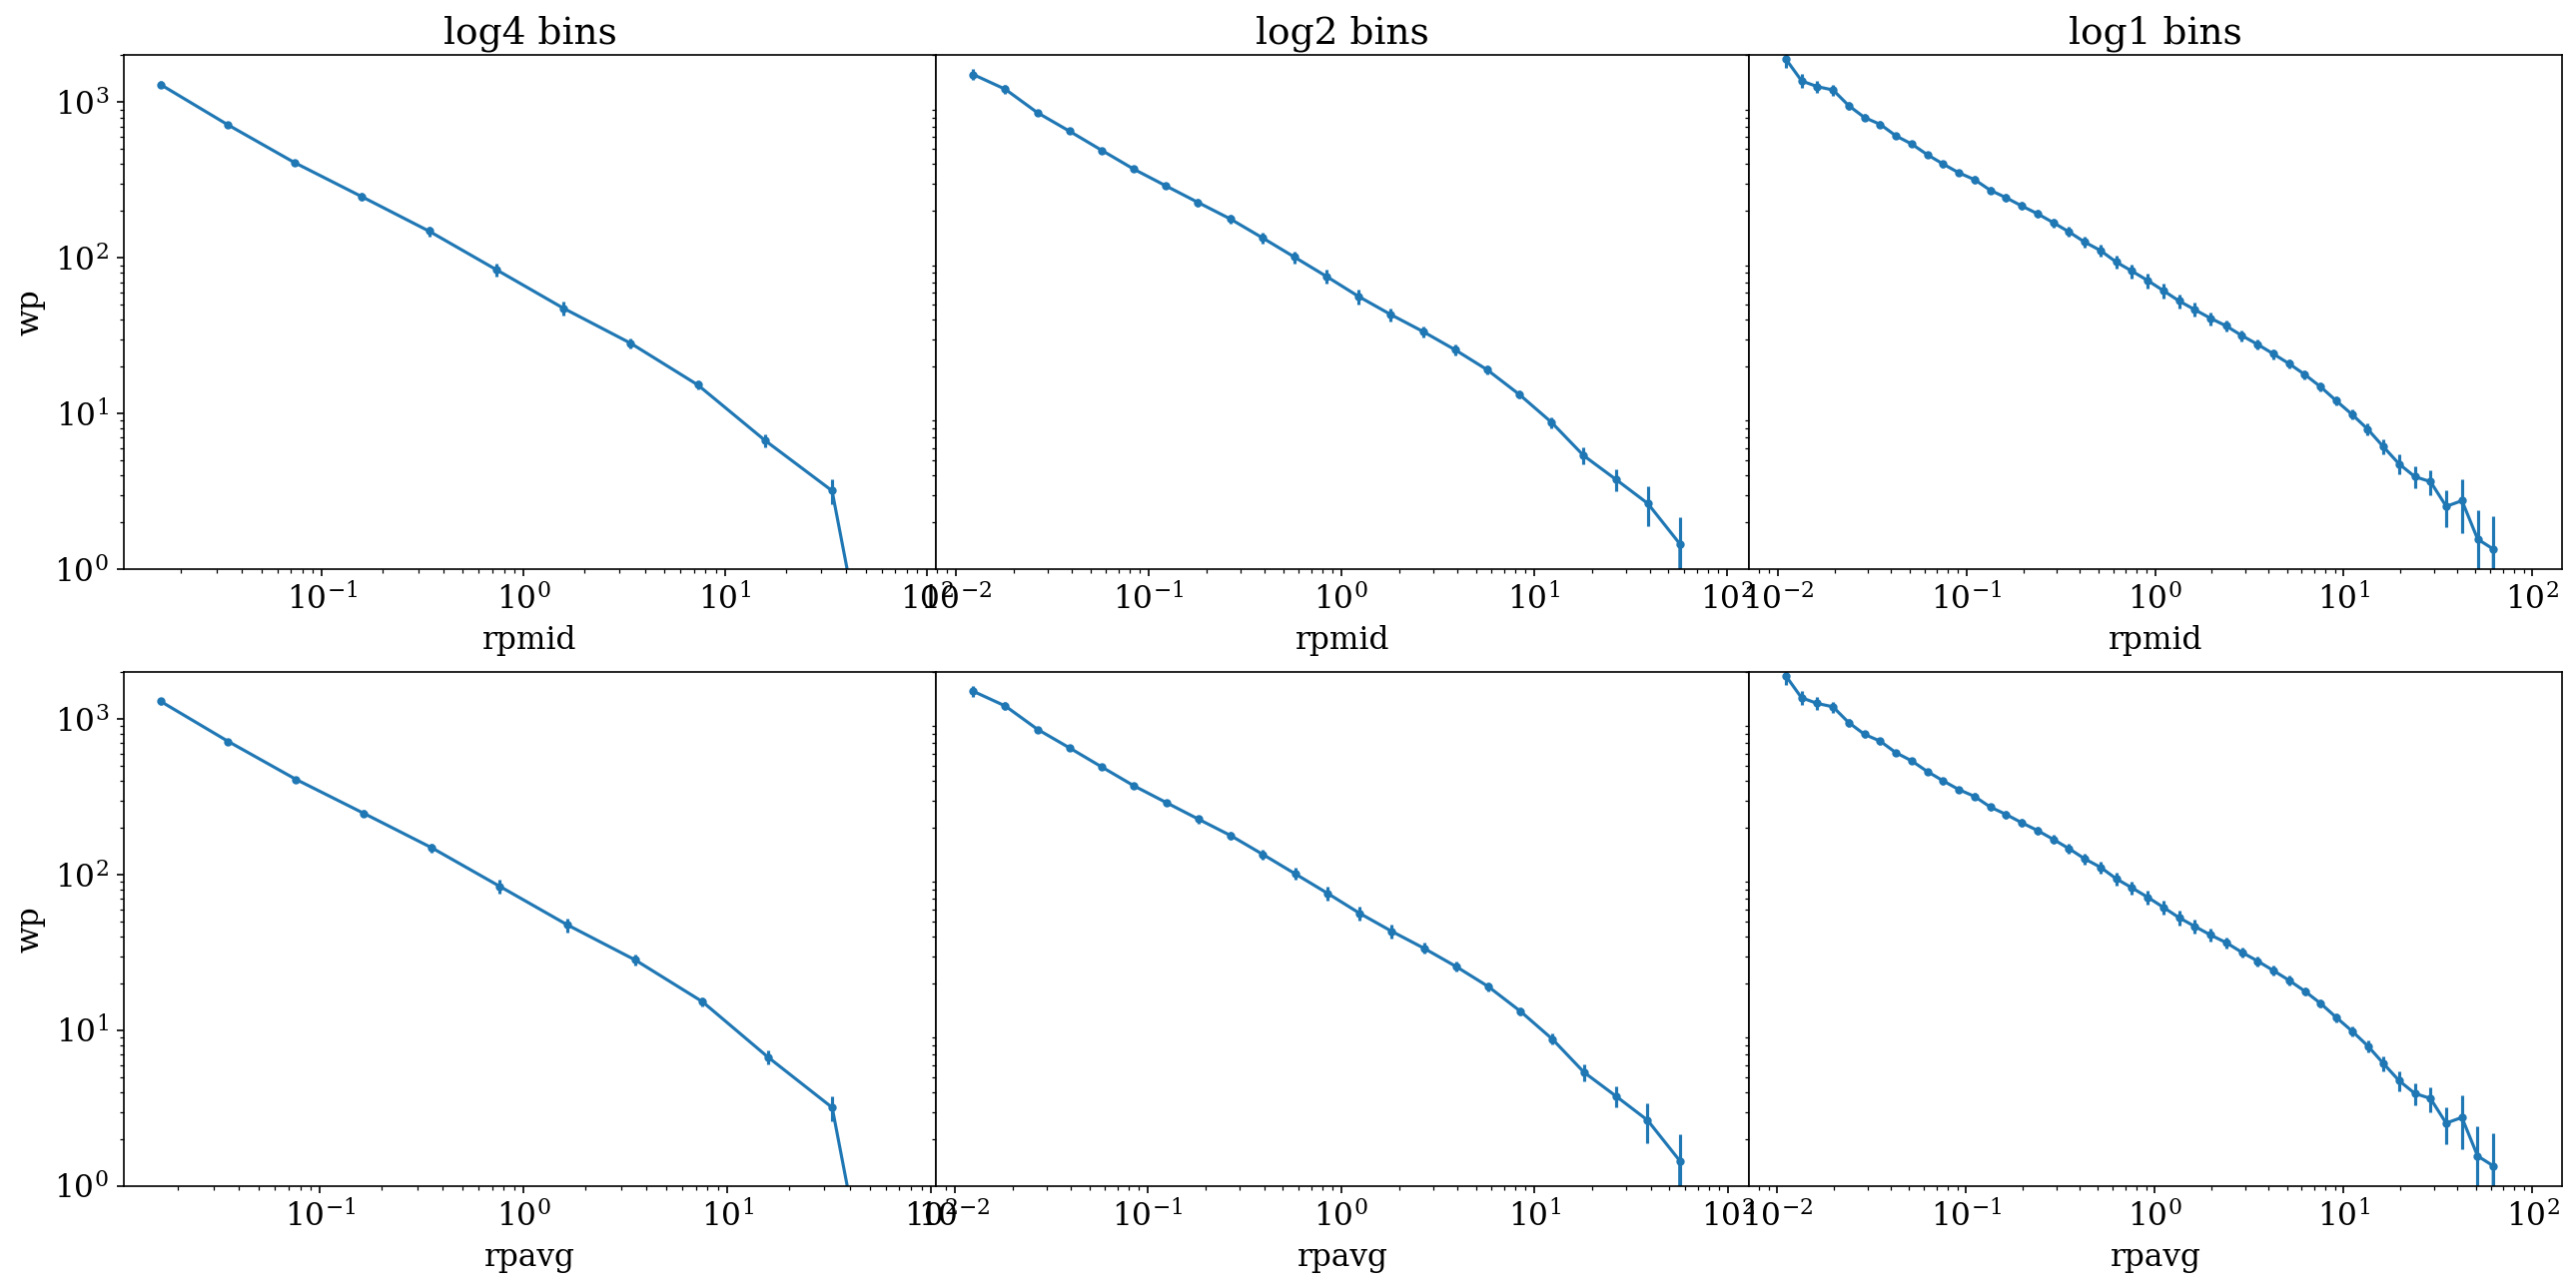

In [3]:
plt.figure(figsize=(21,10), dpi=150)

ax1 = plt.subplot(231)
plt.title('log4 bins')
ax1.errorbar(wp_15log4[:,0], wp_15log4[:,2], yerr=wp_15log4[:,3], marker='o', markersize=3)
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.ylim(1,2*10**3)
plt.ylabel('wp')
plt.xlabel('rpmid')

ax2 = plt.subplot(232)
plt.title('log2 bins')
ax2.errorbar(wp_15log2[:,0], wp_15log2[:,2], yerr=wp_15log2[:,3], marker='o', markersize=3)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yticks([])
plt.ylim(1,2*10**3)
plt.xlabel('rpmid')

ax3 = plt.subplot(233)
plt.title('log1 bins')
ax3.errorbar(wp_15log1[:,0], wp_15log1[:,2], yerr=wp_15log1[:,3], marker='o', markersize=3)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yticks([])
plt.ylim(1,2*10**3)
plt.xlabel('rpmid')

ax4 = plt.subplot(234)
ax4.errorbar(wp_15log4[:,1], wp_15log4[:,2], yerr=wp_15log4[:,3], marker='o', markersize=3)
ax4.set_yscale('log')
ax4.set_xscale('log')
plt.ylim(1,2*10**3)
plt.ylabel('wp')
plt.xlabel('rpavg')

ax5 = plt.subplot(235)
ax5.errorbar(wp_15log2[:,1], wp_15log2[:,2], yerr=wp_15log2[:,3], marker='o', markersize=3)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_yticks([])
plt.ylim(1,2*10**3)
plt.xlabel('rpavg')

ax6 = plt.subplot(236)
ax6.errorbar(wp_15log1[:,1], wp_15log1[:,2], yerr=wp_15log1[:,3], marker='o', markersize=3)
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_yticks([])
plt.ylim(1,2*10**3)
plt.xlabel('rpavg')

plt.subplots_adjust(wspace=0)
plt.show()

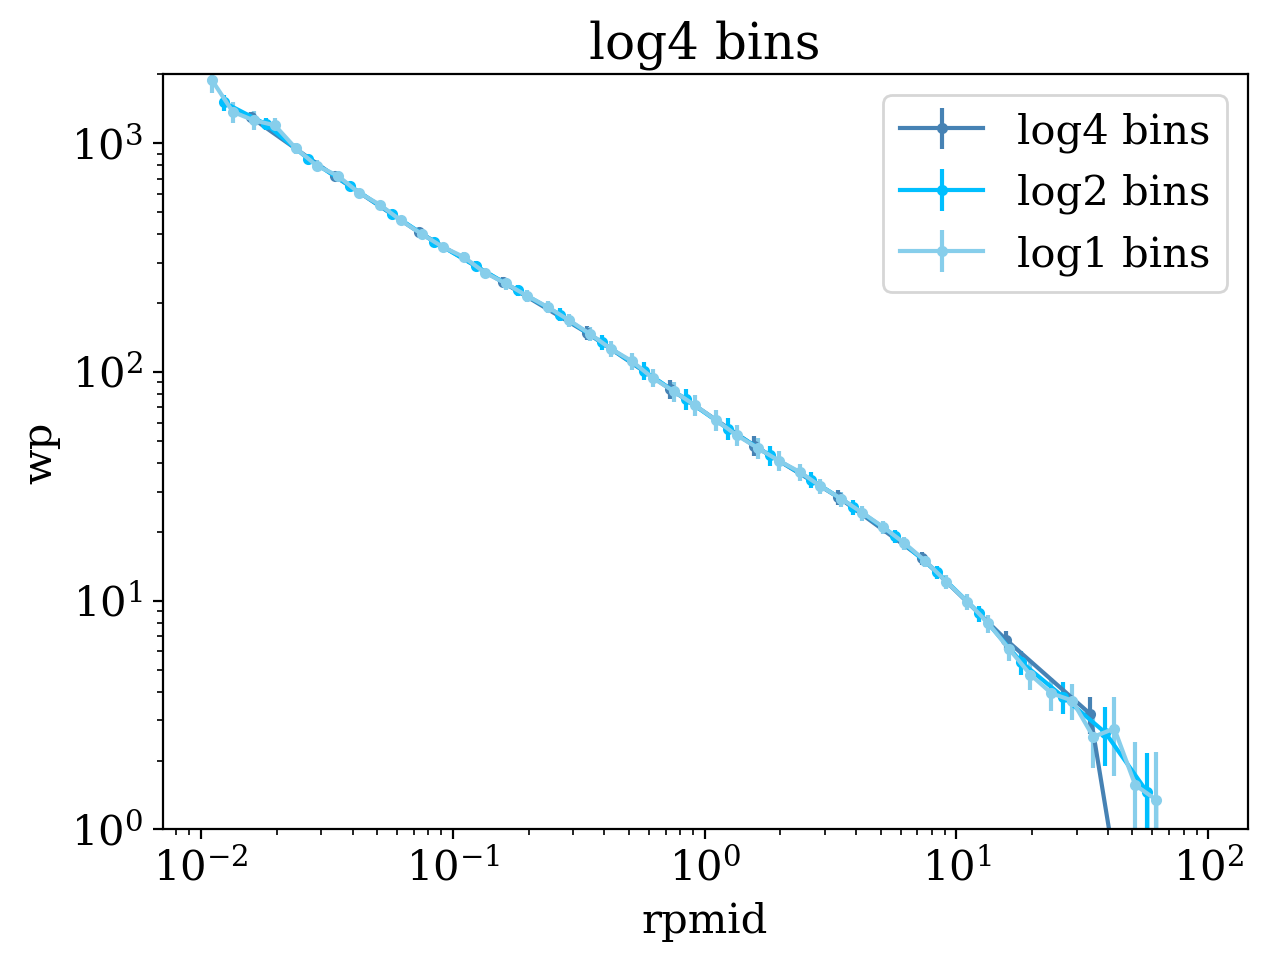

In [4]:
fig, ax1 = plt.subplots(figsize=(7,5), dpi=200)

plt.title('log4 bins')
ax1.errorbar(wp_15log4[:,0], wp_15log4[:,2], yerr=wp_15log4[:,3], marker='o', markersize=3, color='steelblue', label='log4 bins')
ax1.errorbar(wp_15log2[:,0], wp_15log2[:,2], yerr=wp_15log2[:,3], marker='o', markersize=3, color='deepskyblue', label='log2 bins')
ax1.errorbar(wp_15log1[:,0], wp_15log1[:,2], yerr=wp_15log1[:,3], marker='o', markersize=3, color='skyblue', label='log1 bins')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.ylim(1,2*10**3)
plt.ylabel('wp')
plt.xlabel('rpmid')

plt.legend()

plt.show()

Difference between N/S

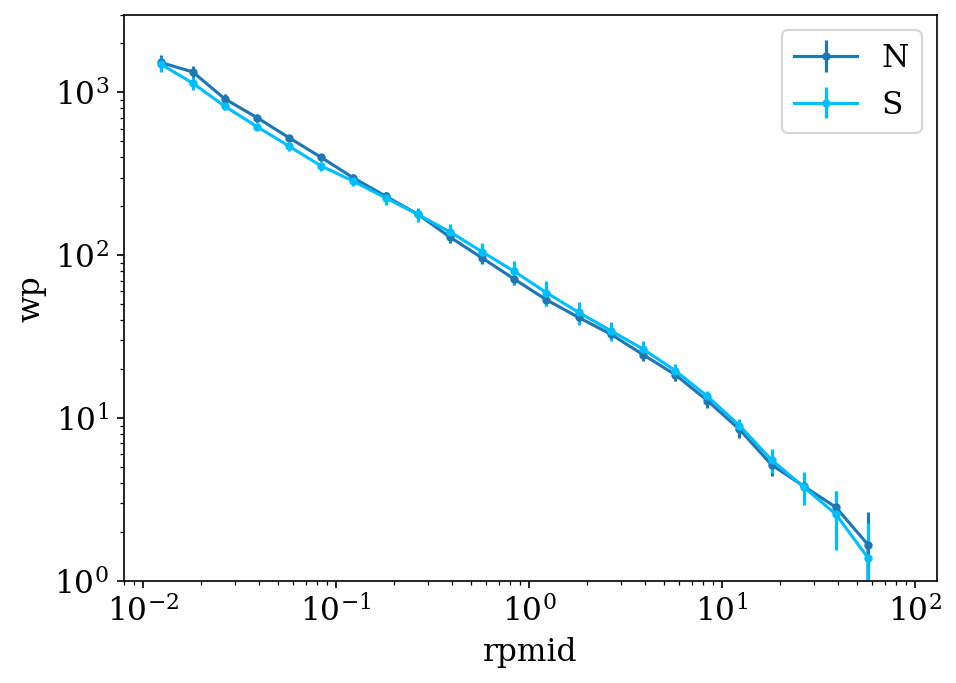

In [5]:
fig, ax1 = plt.subplots(figsize=(7,5),dpi=150)
r_range = np.array([0.01,80])
ax1.errorbar(wp_15log2_N[:,0], wp_15log2_N[:,2], yerr=wp_15log2_N[:,3], marker='o', markersize=3, label='N', color='tab:blue')
ax1.errorbar(wp_15log2_S[:,0], wp_15log2_S[:,2], yerr=wp_15log2_S[:,3], marker='o', markersize=3, label='S', color='deepskyblue')
ax1.set_yscale('log')
plt.ylim(1,3*10**3)
ax1.set_xscale('log')
plt.xlabel('rpmid')
plt.ylabel('wp')
plt.legend()

plt.show()

# Comparison of projected correlation function between SV3 and DA0.2

In [6]:
#columns: smid | savg | corr0(s) | corr2(s) | corr4(s) | std0(s) | std2(s) | std4(s)
#           0      1       2          3          4         5         6         7
xipoles_sv3 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13/smu/xipoles_BGS_BRIGHT_NScomb_0.1_0.5_default_log1_njack60_nran4_split20.txt')
xipoles = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_maglim_18/smu/xipoles_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log1_njack60_nran4_split20.txt')

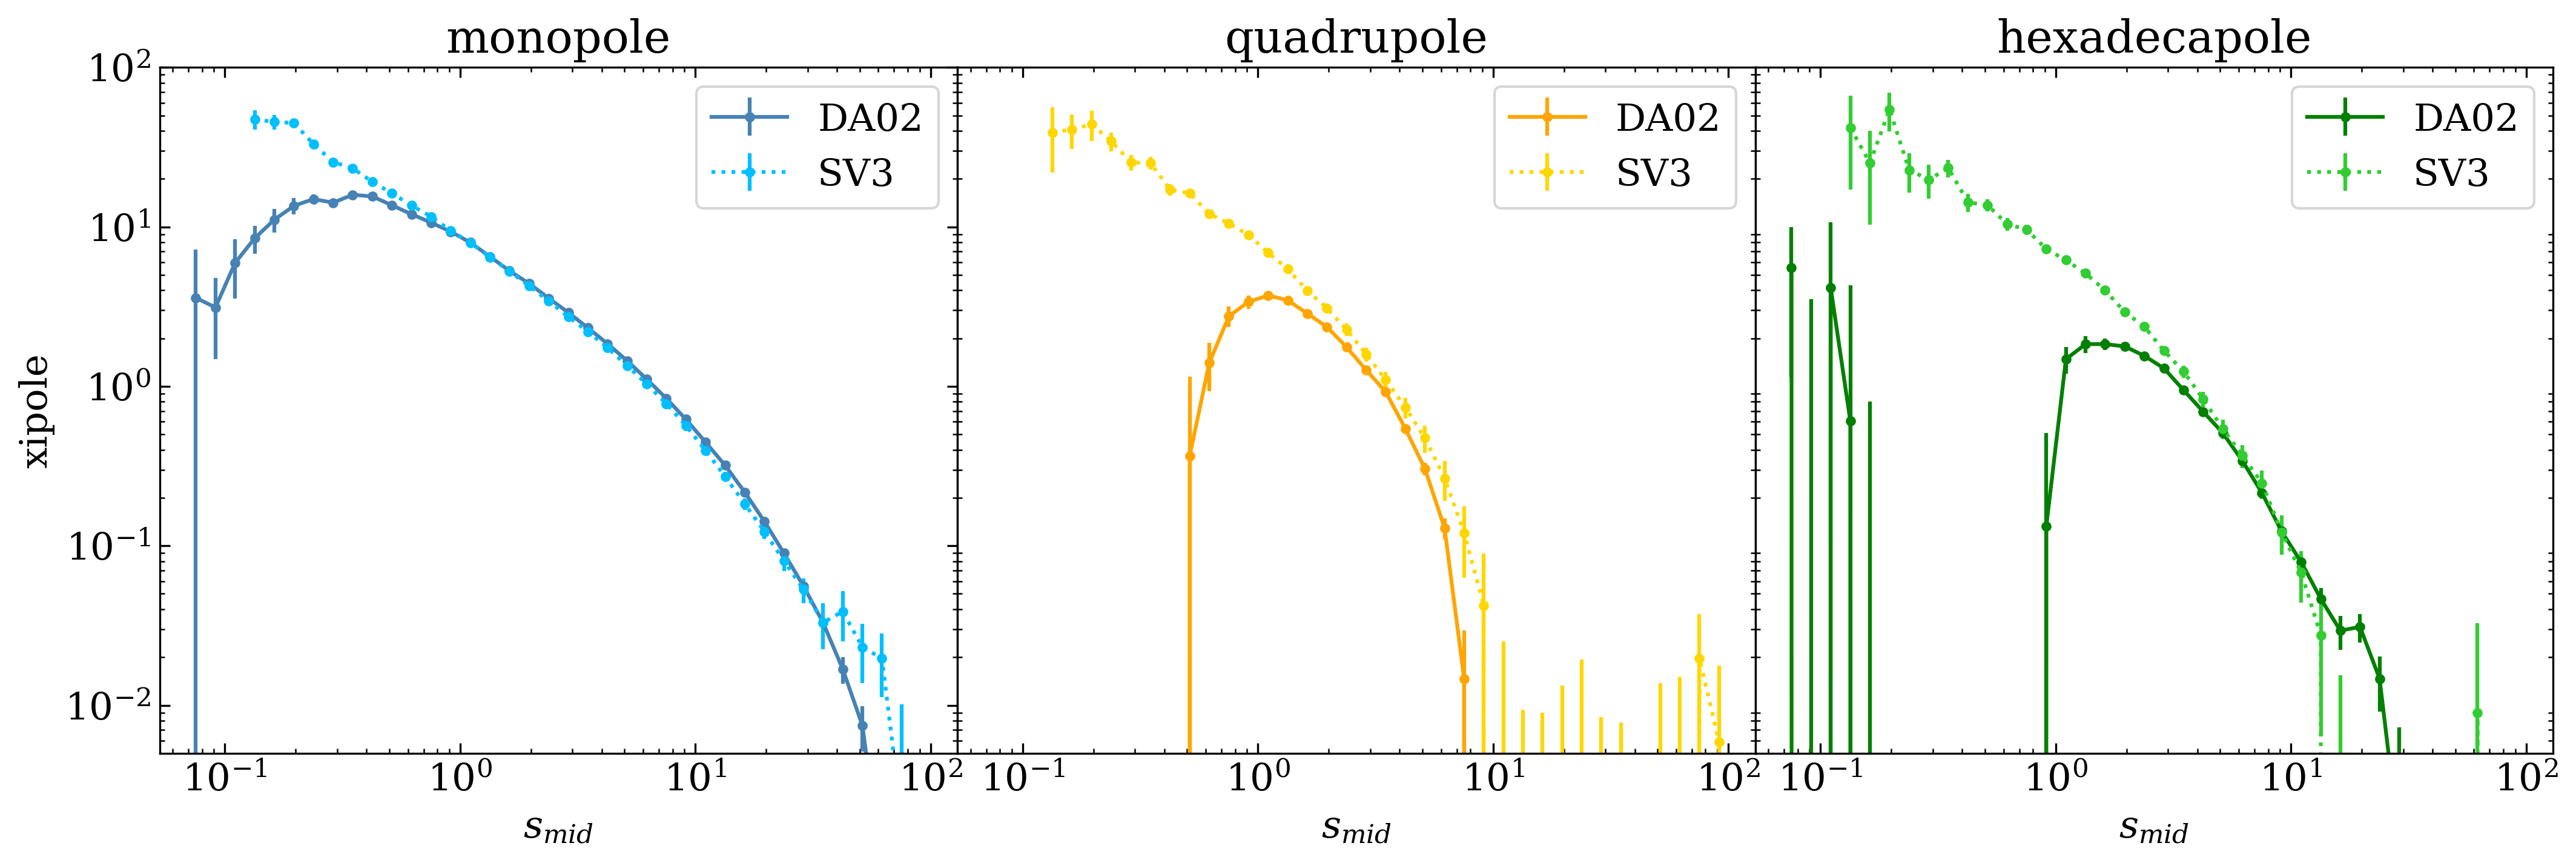

In [7]:
fig, ax = plt.subplots(figsize=(17,5),dpi=300)

ax1 = plt.subplot(131)
plt.title('monopole')
ax1.errorbar(xipoles[:,0], xipoles[:,2], yerr=xipoles[:,5], marker='o', markersize=3, label='DA02', color='steelblue')
ax1.errorbar(xipoles_sv3[:,0], xipoles_sv3[:,2], yerr=xipoles_sv3[:,5], marker='o', markersize=3, label='SV3', color='deepskyblue', ls=':')
plt.xlabel('$s_{mid}$')
plt.ylabel('xipole')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.ylim(5*10**-3, 10**2)
ax1.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax1.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)
plt.legend()

ax2 = plt.subplot(132)
plt.title('quadrupole')
ax2.errorbar(xipoles[:,0], xipoles[:,3], yerr=xipoles[:,6], marker='o', markersize=3, label='DA02', color='orange')
ax2.errorbar(xipoles_sv3[:,0], xipoles_sv3[:,3], yerr=xipoles_sv3[:,6], marker='o', markersize=3, label='SV3', color='gold', ls=':')
plt.xlabel('$s_{mid}$')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yticks([])
plt.ylim(5*10**-3, 10**2)
ax2.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax2.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)
plt.legend()

ax3 = plt.subplot(133)
plt.title('hexadecapole')
ax3.errorbar(xipoles[:,0], xipoles[:,4], yerr=xipoles[:,7], marker='o', markersize=3, label='DA02', color='green')
ax3.errorbar(xipoles_sv3[:,0], xipoles_sv3[:,4], yerr=xipoles_sv3[:,7], marker='o', markersize=3, label='SV3', color='limegreen', ls=':')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yticks([])
plt.ylim(5*10**-3, 10**2)
plt.xlabel('$s_{mid}$')
ax3.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax3.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)
plt.legend()

plt.subplots_adjust(wspace=0)
plt.show()

In [8]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
wp_sv3 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5_default_log2_njack60_nran4_split20.txt')
wp_da02 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_no_maglim_fullonly/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')


wp_sv3_N = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13/rppi/wp_BGS_BRIGHT_N_0.1_0.5_default_log2_njack60_nran4_split20.txt')
wp_sv3_S = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13/rppi/wp_BGS_BRIGHT_S_0.1_0.5_default_log2_njack60_nran4_split20.txt')

wp_da02_N = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_no_maglim_da02_newkcorrs/rppi/wp_BGS_BRIGHT_N_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_da02_S = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_no_maglim_da02_newkcorrs/rppi/wp_BGS_BRIGHT_S_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')

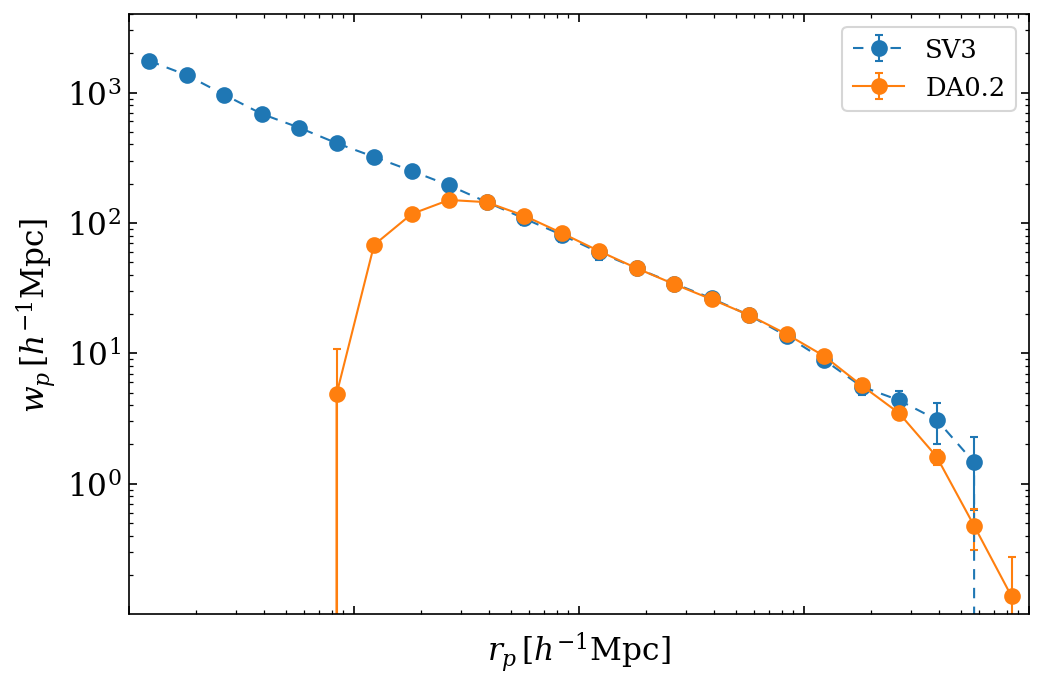

In [9]:
fig = plt.figure(dpi=150)
plt.rcParams['font.size'] = 15
ax1 = fig.add_axes((0,0,1,1))
ax1.errorbar(wp_sv3[:,0], wp_sv3[:,2], yerr=wp_sv3[:,3], marker='o', markersize=7, capsize=2, lw=1, elinewidth=1, ls=(0,(5,4)), color='tab:blue', label='SV3')
ax1.errorbar(wp_da02[:,0], wp_da02[:,2], yerr=wp_da02[:,3], marker='o', markersize=7, capsize=2, lw=1, elinewidth=1, color='tab:orange', label='DA0.2')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xticklabels([])
plt.ylim(0.1,4*10**3)
ax1.set_yticks([10**0,10**1,10**2,10**3])
plt.ylabel('$w_p \, [h^{-1}\mathrm{Mpc}]$')
plt.xlabel('$r_p \, [h^{-1}\mathrm{Mpc}]$')
plt.xlim(0.01,100)

ax1.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax1.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)

plt.legend(loc='upper right', fontsize=12.4)

plt.show()

In [4]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
wp_sv3_red = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13_colour/red/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5_default_log2_njack60_nran4_split20.txt')
wp_sv3_blue = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13_colour/blue/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_sv3 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5_default_log2_njack60_nran4_split20.txt')

In [5]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['font.size'] = 15

# SV3 projected correlation function split by colour

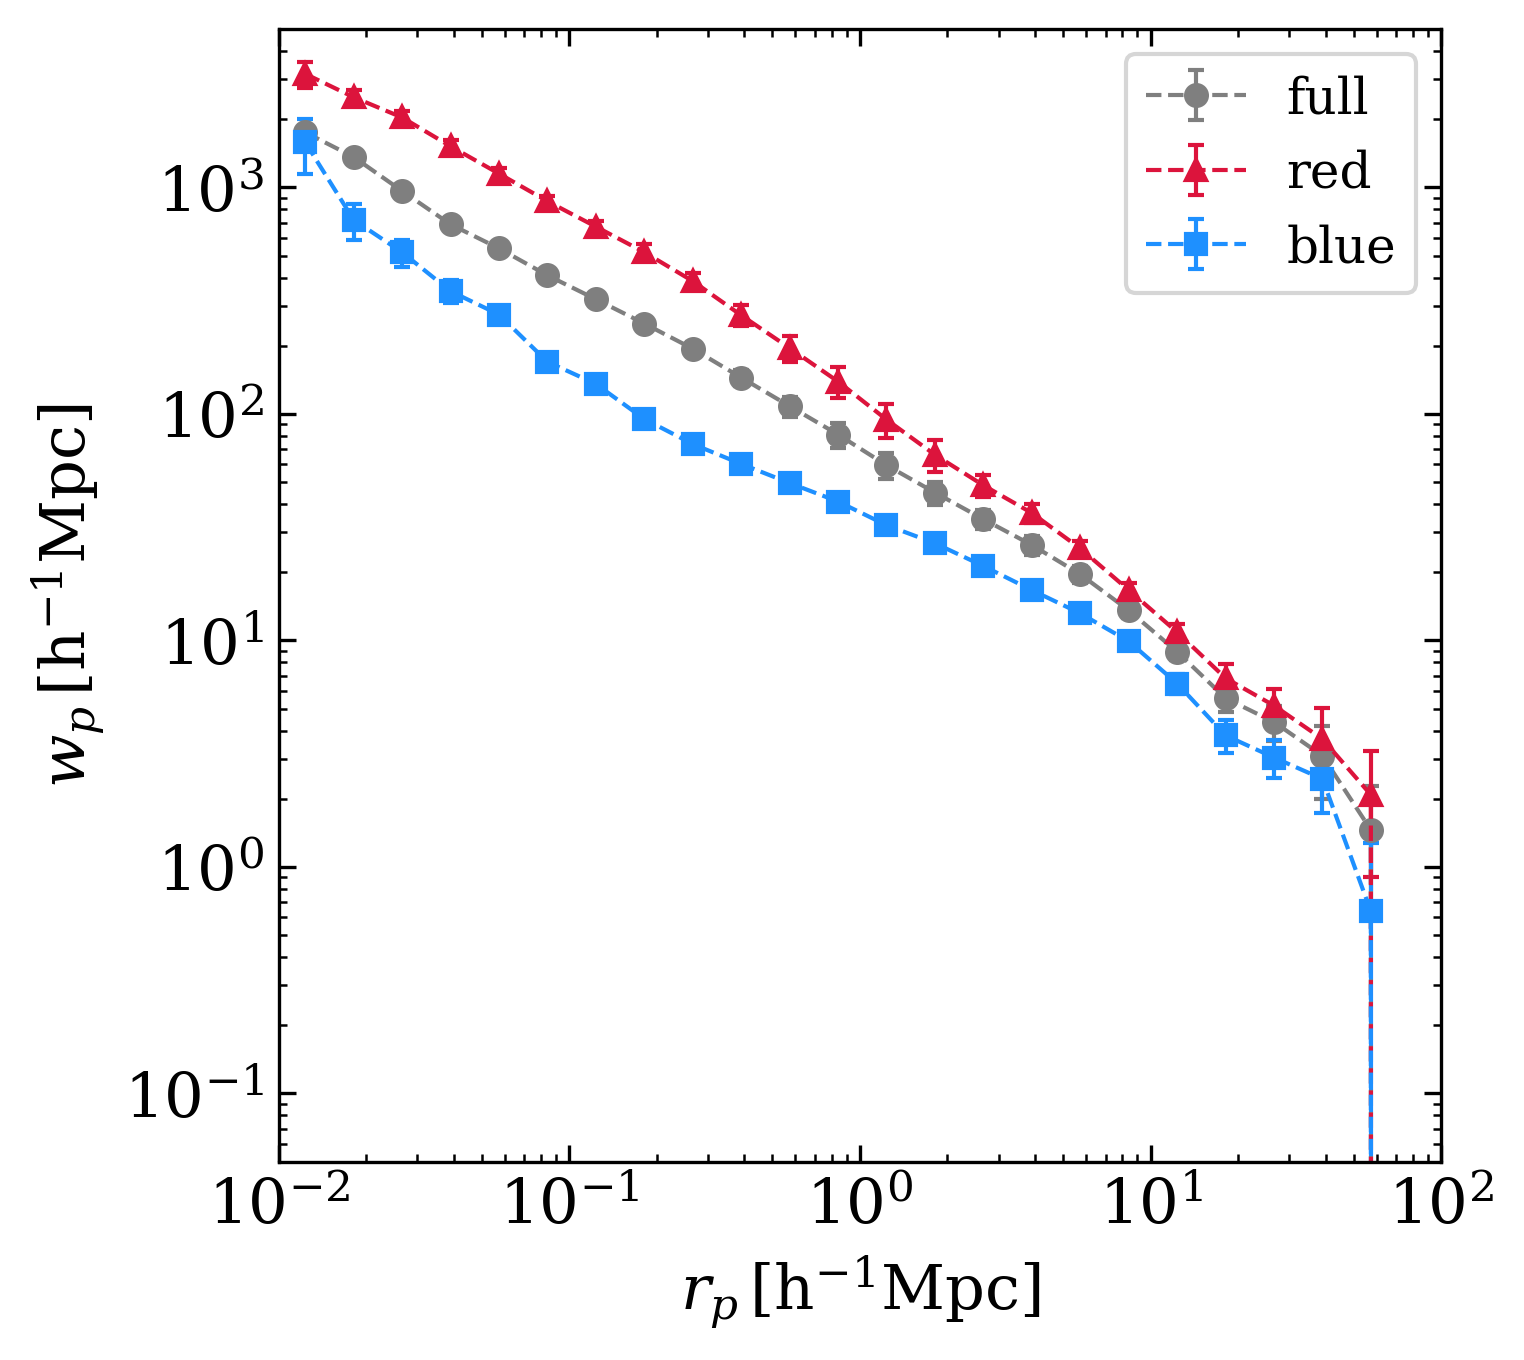

In [6]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.errorbar(wp_sv3[:,0], wp_sv3[:,2], yerr=wp_sv3[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='tab:grey', ls='--', marker='o', label='full')
ax.errorbar(wp_sv3_red[:,0], wp_sv3_red[:,2], yerr=wp_sv3_red[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='crimson', marker='^', ls='--', label='red')
ax.errorbar(wp_sv3_blue[:,0], wp_sv3_blue[:,2], yerr=wp_sv3_blue[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='dodgerblue', marker='s', ls='--', label='blue')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**-2, 10**2)
plt.ylim(0.05, 5*10**3)
plt.ylabel('$w_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')
plt.xlabel('$r_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')

legend_elements =  [Line2D([0], [0], marker='^',  color='crimson', mec='crimson', mfc='None', label='red', linestyle='',ms=5),
                   Line2D([0], [0], marker='o', color='tab:grey', label='full', linestyle='',ms=5),
                   Line2D([0], [0], marker='s', color='dodgerblue',  mec='dodgerblue', mfc='None', label='blue', linestyle='',ms=5)]

plt.legend(fontsize=12)

ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)


plt.show()

In [2]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
da02_red = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_maglim_13_colour_newkcorrs/red/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
da02_blue = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_maglim_13_colour_newkcorrs/blue/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
da02 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_no_maglim_da02_newkcorrs/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')

# DA0.2 projected correlation function split by colour

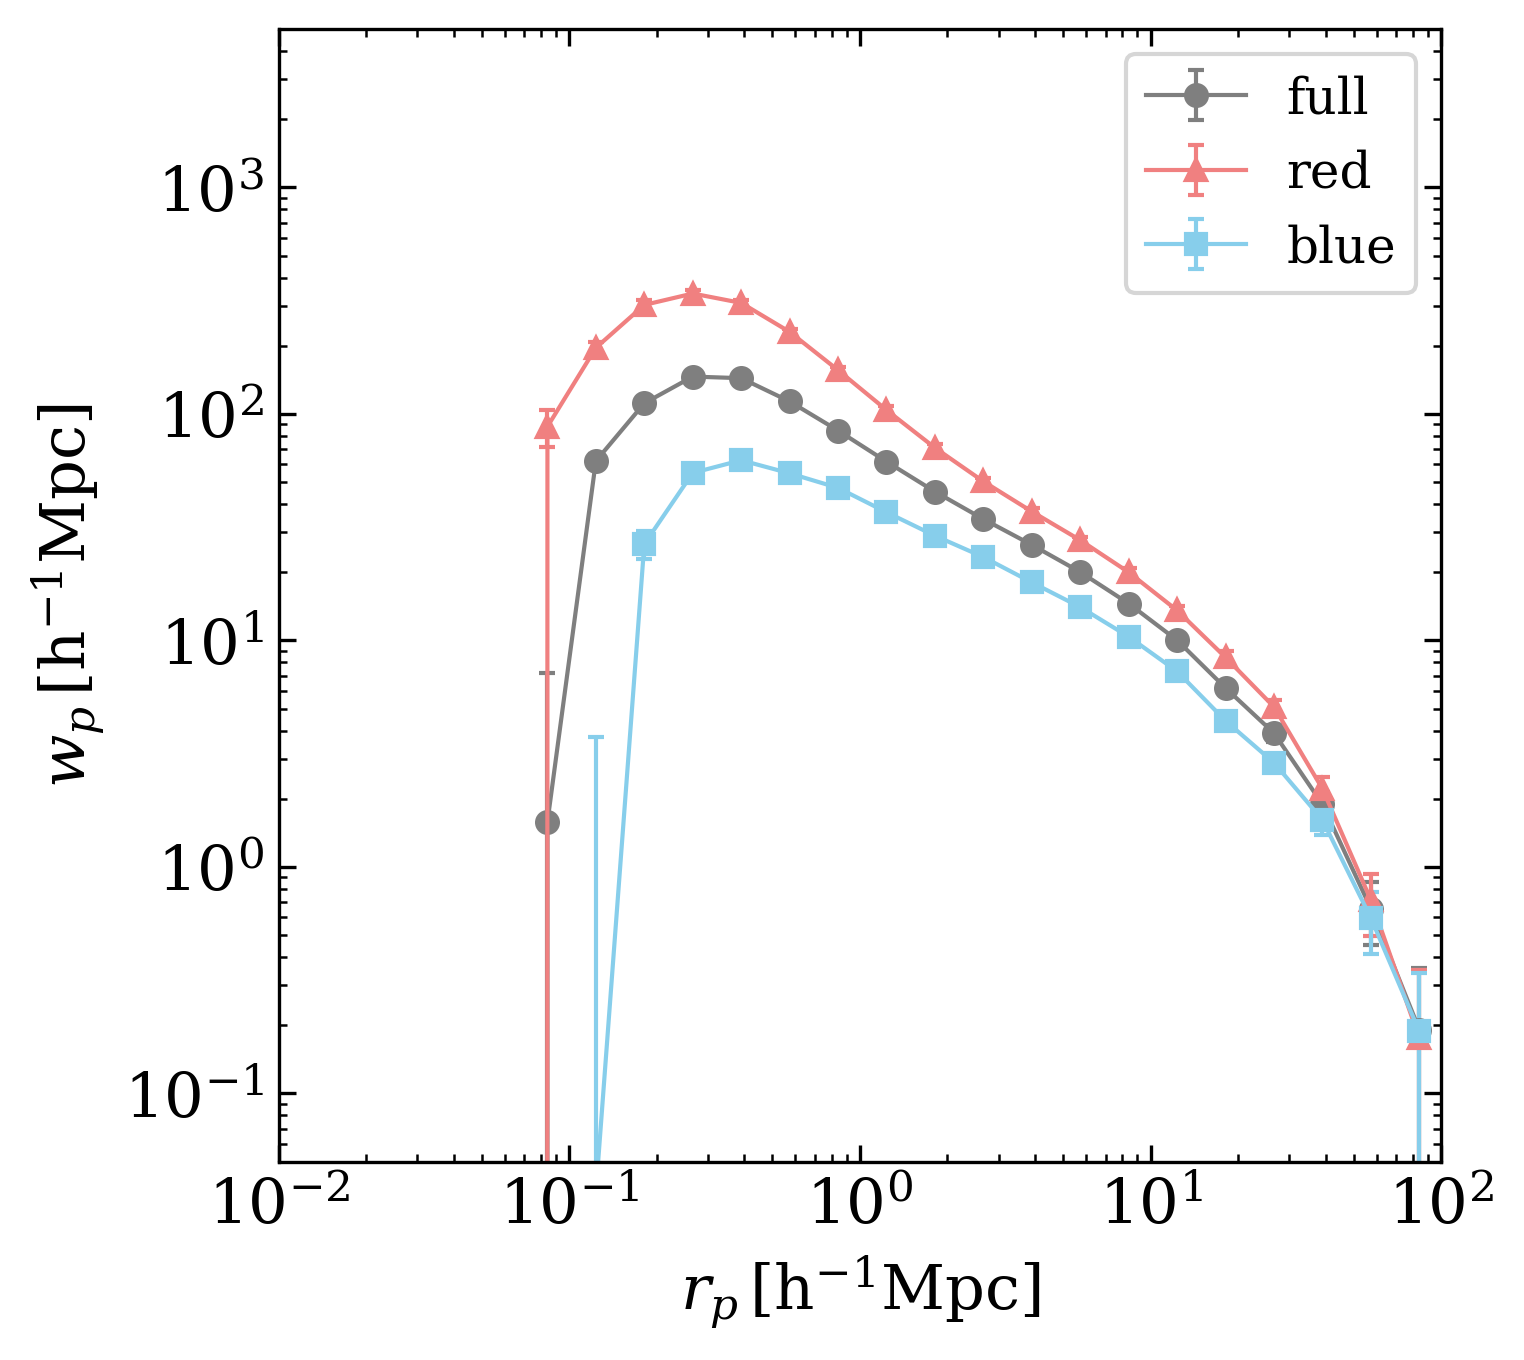

In [4]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.errorbar(da02[:,0], da02[:,2], yerr=da02[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='tab:grey', marker='o', label='full')
ax.errorbar(da02_red[:,0], da02_red[:,2], yerr=da02_red[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='lightcoral', marker='^', label='red')
ax.errorbar(da02_blue[:,0], da02_blue[:,2], yerr=da02_blue[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='skyblue', marker='s', label='blue')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**-2, 10**2)
plt.ylim(0.05, 5*10**3)
plt.ylabel('$w_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')
plt.xlabel('$r_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')

legend_elements =  [Line2D([0], [0], marker='^',  color='crimson', mec='crimson', mfc='None', label='red', linestyle='',ms=5),
                   Line2D([0], [0], marker='o', color='tab:grey', label='full', linestyle='',ms=5),
                   Line2D([0], [0], marker='s', color='dodgerblue',  mec='dodgerblue', mfc='None', label='blue', linestyle='',ms=5)]

plt.legend(fontsize=12)

ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)


plt.show()

In [7]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
sv3_red = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13_colour/red/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5_default_log2_njack60_nran4_split20.txt')
sv3_blue = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13_colour/blue/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
sv3 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_maglim_13/rppi/wp_BGS_BRIGHT_NScomb_0.1_0.5_default_log2_njack60_nran4_split20.txt')

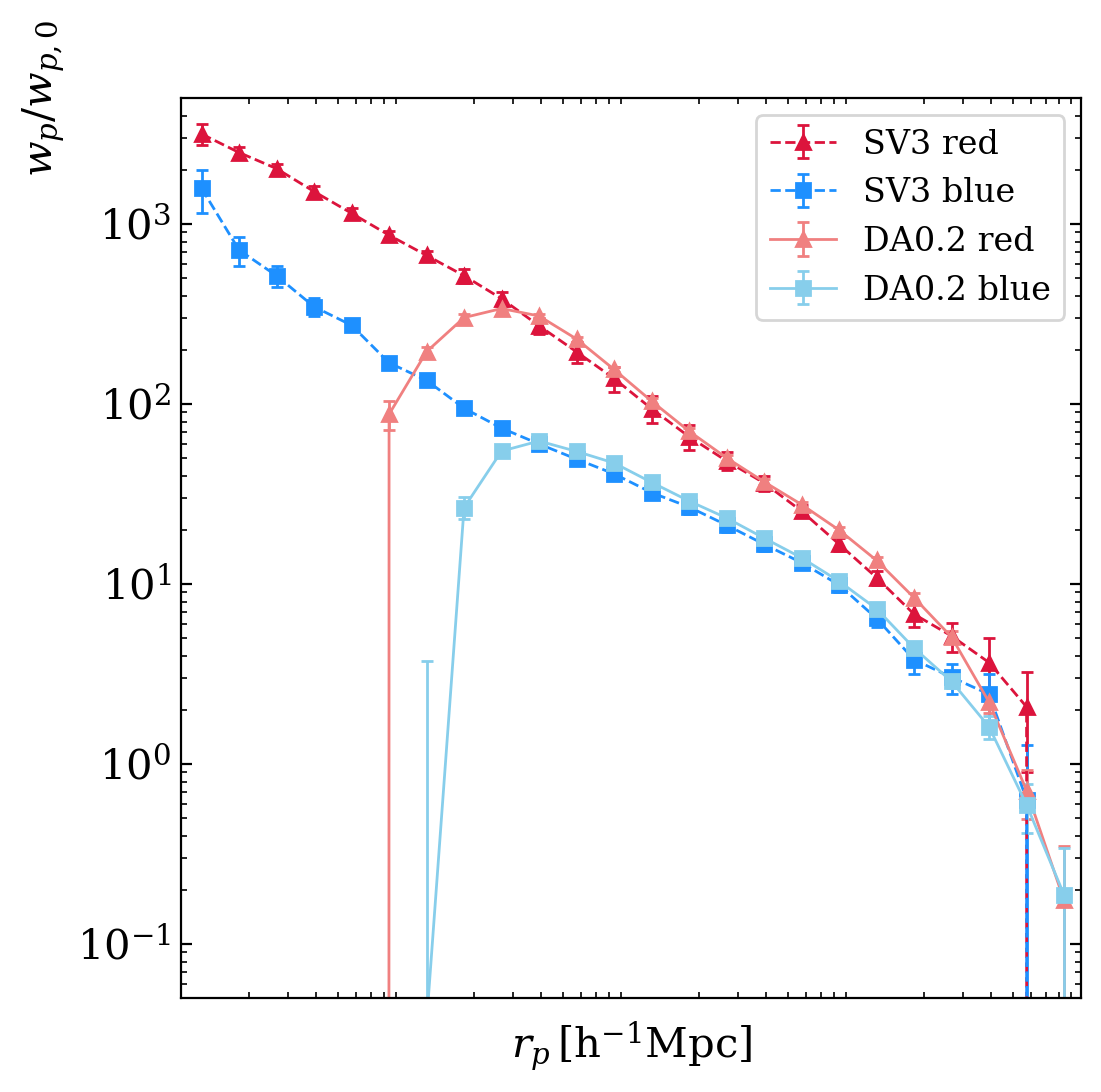

In [8]:
from matplotlib.lines import Line2D

ficid_power_red = pl.power_law(sv3_red[:,0], [6.5,1.9])
ficid_power_blue = pl.power_law(sv3_blue[:,0], [3.7,1.56])

fig = plt.figure(figsize=(4.5,4.5), dpi=200)

ax = fig.add_axes([0,0,1,1])

ax.errorbar(sv3_red[:,0], sv3_red[:,2], yerr=sv3_red[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, ls='--', color='crimson', marker='^', label='SV3 red')
ax.errorbar(sv3_blue[:,0], sv3_blue[:,2], yerr=sv3_blue[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, ls='--', color='dodgerblue', marker='s', label='SV3 blue')

ax.errorbar(da02_red[:,0], da02_red[:,2], yerr=da02_red[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='lightcoral', marker='^', label='DA0.2 red')
ax.errorbar(da02_blue[:,0], da02_blue[:,2], yerr=da02_blue[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='skyblue', marker='s', label='DA0.2 blue')

ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**-2, 10**2)
plt.ylim(0.05, 5*10**3)
ax.set_xticks([])
plt.ylabel('$w_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')

legend_elements =  [Line2D([0], [0], marker='^',  color='crimson', label='SV3 red', linestyle='',ms=5),
                   Line2D([0], [0], marker='s', color='dodgerblue',  label='SV3 blue', linestyle='',ms=5),
                   Line2D([0], [0], marker='^',  color='lightcoral', label='DA0.2 red', linestyle='',ms=5),
                   Line2D([0], [0], marker='s', color='skyblue',  label='DA0.2 blue', linestyle='',ms=5)]

plt.legend(fontsize=12)

ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)

plt.ylabel('$w_p/w_{p,0}$', y=1)

plt.xlabel('$r_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')


plt.show()

# SV3 projected correlation function in volume-limited samples 

In [11]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
wp_17_18 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_magbins/17_18/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_18_19 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_magbins/18_19/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_19_20 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_magbins/19_20/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_20_21 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_magbins/20_21/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_21_22 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_magbins/21_22/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_22_23 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/sv3_magbins/22_23/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')

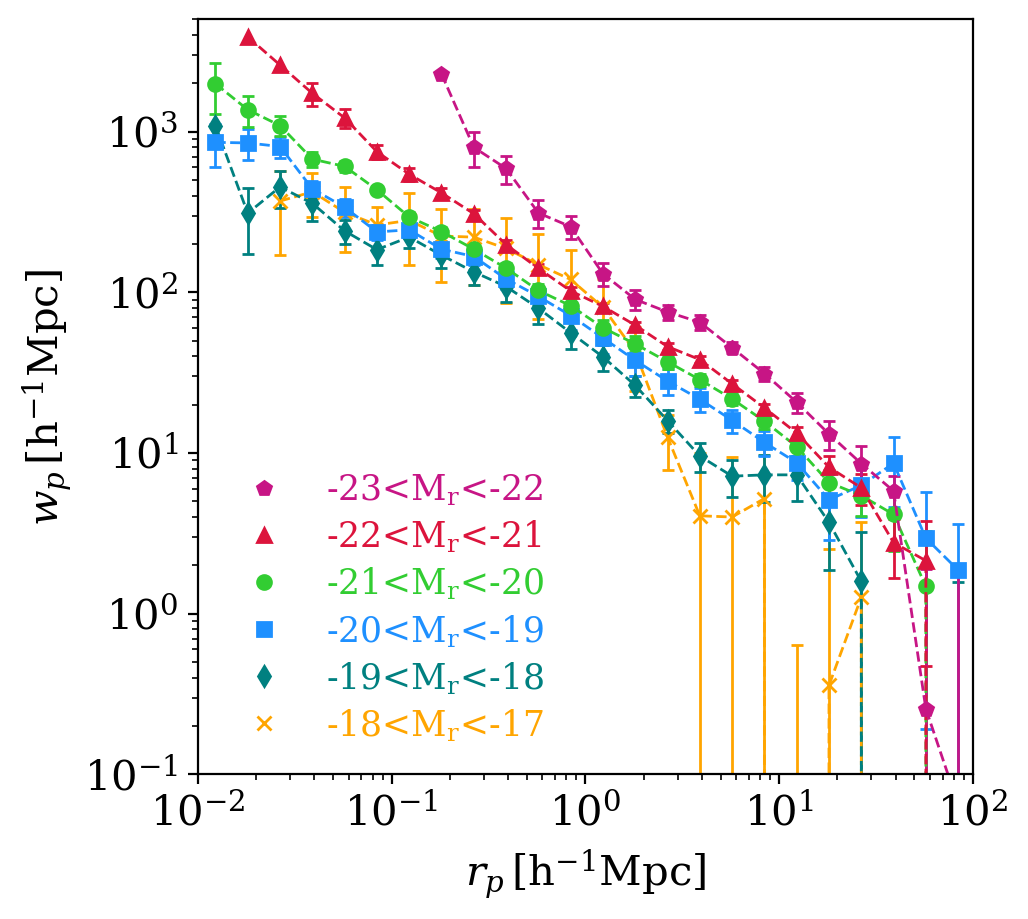

In [12]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), dpi=200)

ax.errorbar(wp_17_18[:,0], wp_17_18[:,2], yerr=wp_17_18[:,3], ls='--', markersize=5, lw=1, elinewidth=1, capsize=2, color='orange', marker='x')
ax.errorbar(wp_18_19[:,0], wp_18_19[:,2], yerr=wp_18_19[:,3], ls='--', markersize=5, lw=1, elinewidth=1, capsize=2, color='teal', marker='d')
ax.errorbar(wp_19_20[:,0], wp_19_20[:,2], yerr=wp_19_20[:,3], ls='--', markersize=5, lw=1, elinewidth=1, capsize=2, color='dodgerblue', marker='s')
ax.errorbar(wp_20_21[:,0], wp_20_21[:,2], yerr=wp_20_21[:,3], ls='--', markersize=5, lw=1, elinewidth=1, capsize=2, color='limegreen', marker='o')
ax.errorbar(wp_21_22[:,0], wp_21_22[:,2], yerr=wp_21_22[:,3], ls='--', markersize=5, lw=1, elinewidth=1, capsize=2, color='crimson', marker='^')
ax.errorbar(wp_22_23[:,0], wp_22_23[:,2], yerr=wp_22_23[:,3], ls='--', markersize=5, lw=1, elinewidth=1, capsize=2, color='mediumvioletred', marker='p')


ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**-2, 10**2)
plt.ylim(0.1, 5*10**3)
plt.ylabel('$w_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')
plt.xlabel('$r_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')

legend_elements =  [Line2D([0], [0], marker='p', lw=1, color='mediumvioletred', label='-23<$\mathrm{M_{r}}$<-22', linestyle='',ms=5),
                    Line2D([0], [0], marker='^', lw=1, color='crimson', label='-22<$\mathrm{M_{r}}$<-21', linestyle='',ms=5),
                    Line2D([0], [0], marker='o', lw=1, color='limegreen', label='-21<$\mathrm{M_{r}}$<-20', linestyle='',ms=5),
                    Line2D([0], [0], marker='s', lw=1, color='dodgerblue', label='-20<$\mathrm{M_{r}}$<-19', linestyle='',ms=5),
                    Line2D([0], [0], marker='d', lw=1, color='teal', label='-19<$\mathrm{M_{r}}$<-18', linestyle='',ms=5),
                    Line2D([0], [0], marker='x', lw=1, color='orange', label='-18<$\mathrm{M_{r}}$<-17', linestyle='',ms=5)]

plt.legend(handles=legend_elements, fontsize='small', frameon=False, labelcolor='linecolor', labelspacing=0.3)

plt.show()

# DA0.2 projected correlation function in volume-limited samples 

In [13]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
wp_17_18 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_magbins_newkcorrs/17_18/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')#[8:]
wp_18_19 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_magbins_newkcorrs/18_19/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')#[8:]
wp_19_20 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_magbins_newkcorrs/19_20/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')#[8:]
wp_20_21 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_magbins_newkcorrs/20_21/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')#[9:]
wp_21_22 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_magbins_newkcorrs/21_22/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')#[10:]
wp_22_23 = np.genfromtxt('/pscratch/sd/e/edown/clustering/outdir_xirunpc/da02_magbins_newkcorrs/22_23/rppi/wp_BGS_BRIGHT_NS_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')#[11:]

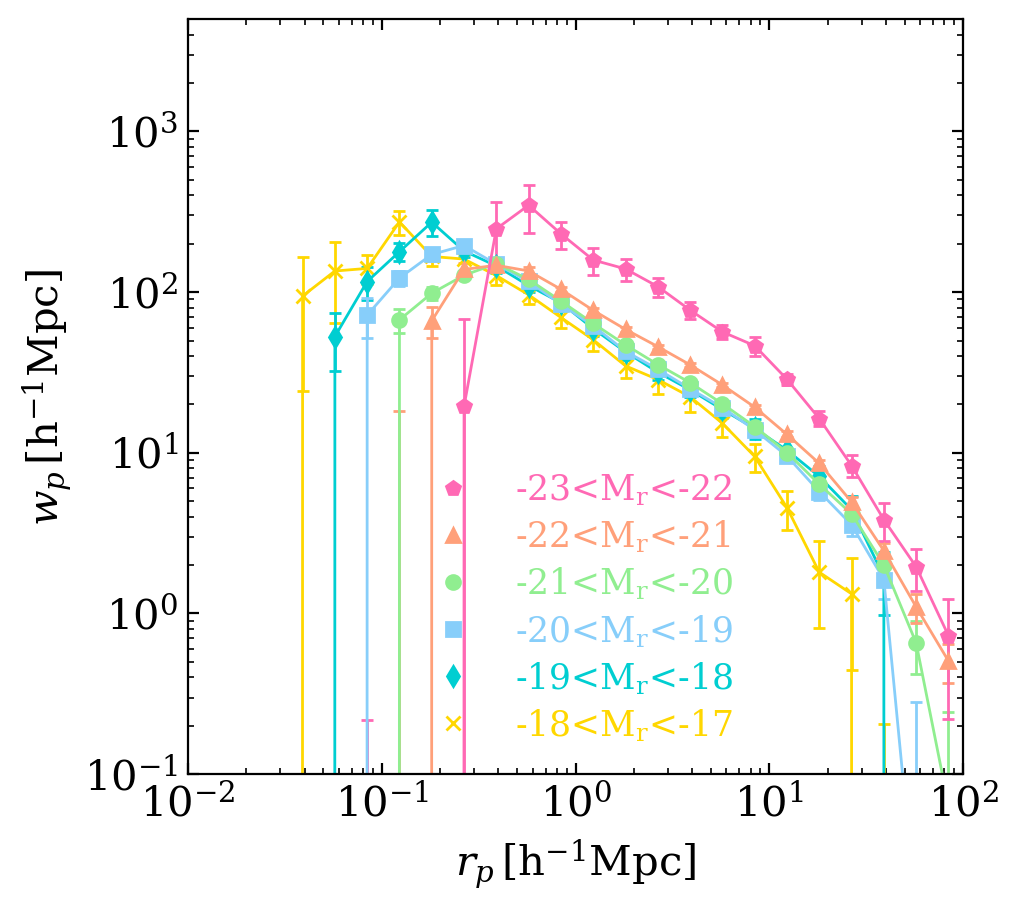

In [14]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.errorbar(wp_17_18[:,0], wp_17_18[:,2], yerr=wp_17_18[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='gold', marker='x')
ax.errorbar(wp_18_19[:,0], wp_18_19[:,2], yerr=wp_18_19[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='darkturquoise', marker='d')
ax.errorbar(wp_19_20[:,0], wp_19_20[:,2], yerr=wp_19_20[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='lightskyblue', marker='s')
ax.errorbar(wp_20_21[:,0], wp_20_21[:,2], yerr=wp_20_21[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='lightgreen', marker='o')
ax.errorbar(wp_21_22[:,0], wp_21_22[:,2], yerr=wp_21_22[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='lightsalmon', marker='^')
ax.errorbar(wp_22_23[:,0], wp_22_23[:,2], yerr=wp_22_23[:,3], markersize=5, lw=1, elinewidth=1, capsize=2, color='hotpink', marker='p')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(10**-2, 10**2)
plt.ylim(0.1, 5*10**3)
plt.ylabel('$w_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')
plt.xlabel('$r_p \, [\mathrm{h}^{-1}\mathrm{Mpc}]$')

legend_elements =  [Line2D([0], [0], marker='p', color='hotpink', label='-23<$\mathrm{M_{r}}$<-22', linestyle='',ms=5),
                    Line2D([0], [0], marker='^', color='lightsalmon', label='-22<$\mathrm{M_{r}}$<-21', linestyle='',ms=5),
                    Line2D([0], [0], marker='o', color='lightgreen', label='-21<$\mathrm{M_{r}}$<-20', linestyle='',ms=5),
                    Line2D([0], [0], marker='s', color='lightskyblue', label='-20<$\mathrm{M_{r}}$<-19', linestyle='',ms=5),
                   Line2D([0], [0], marker='d', color='darkturquoise', label='-19<$\mathrm{M_{r}}$<-18', linestyle='',ms=5),
                   Line2D([0], [0], marker='x', color='gold', label='-18<$\mathrm{M_{r}}$<-17', linestyle='',ms=5),]

plt.legend(handles=legend_elements, fontsize='small', frameon=False, labelcolor='linecolor', labelspacing=0.3)

ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)
ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True, length=2)


plt.show()